# Jupyter Notebook to access the IBM RXN API

## This notebook can be used to to generate retrosynthetic routes to compounds selected from the docking studies

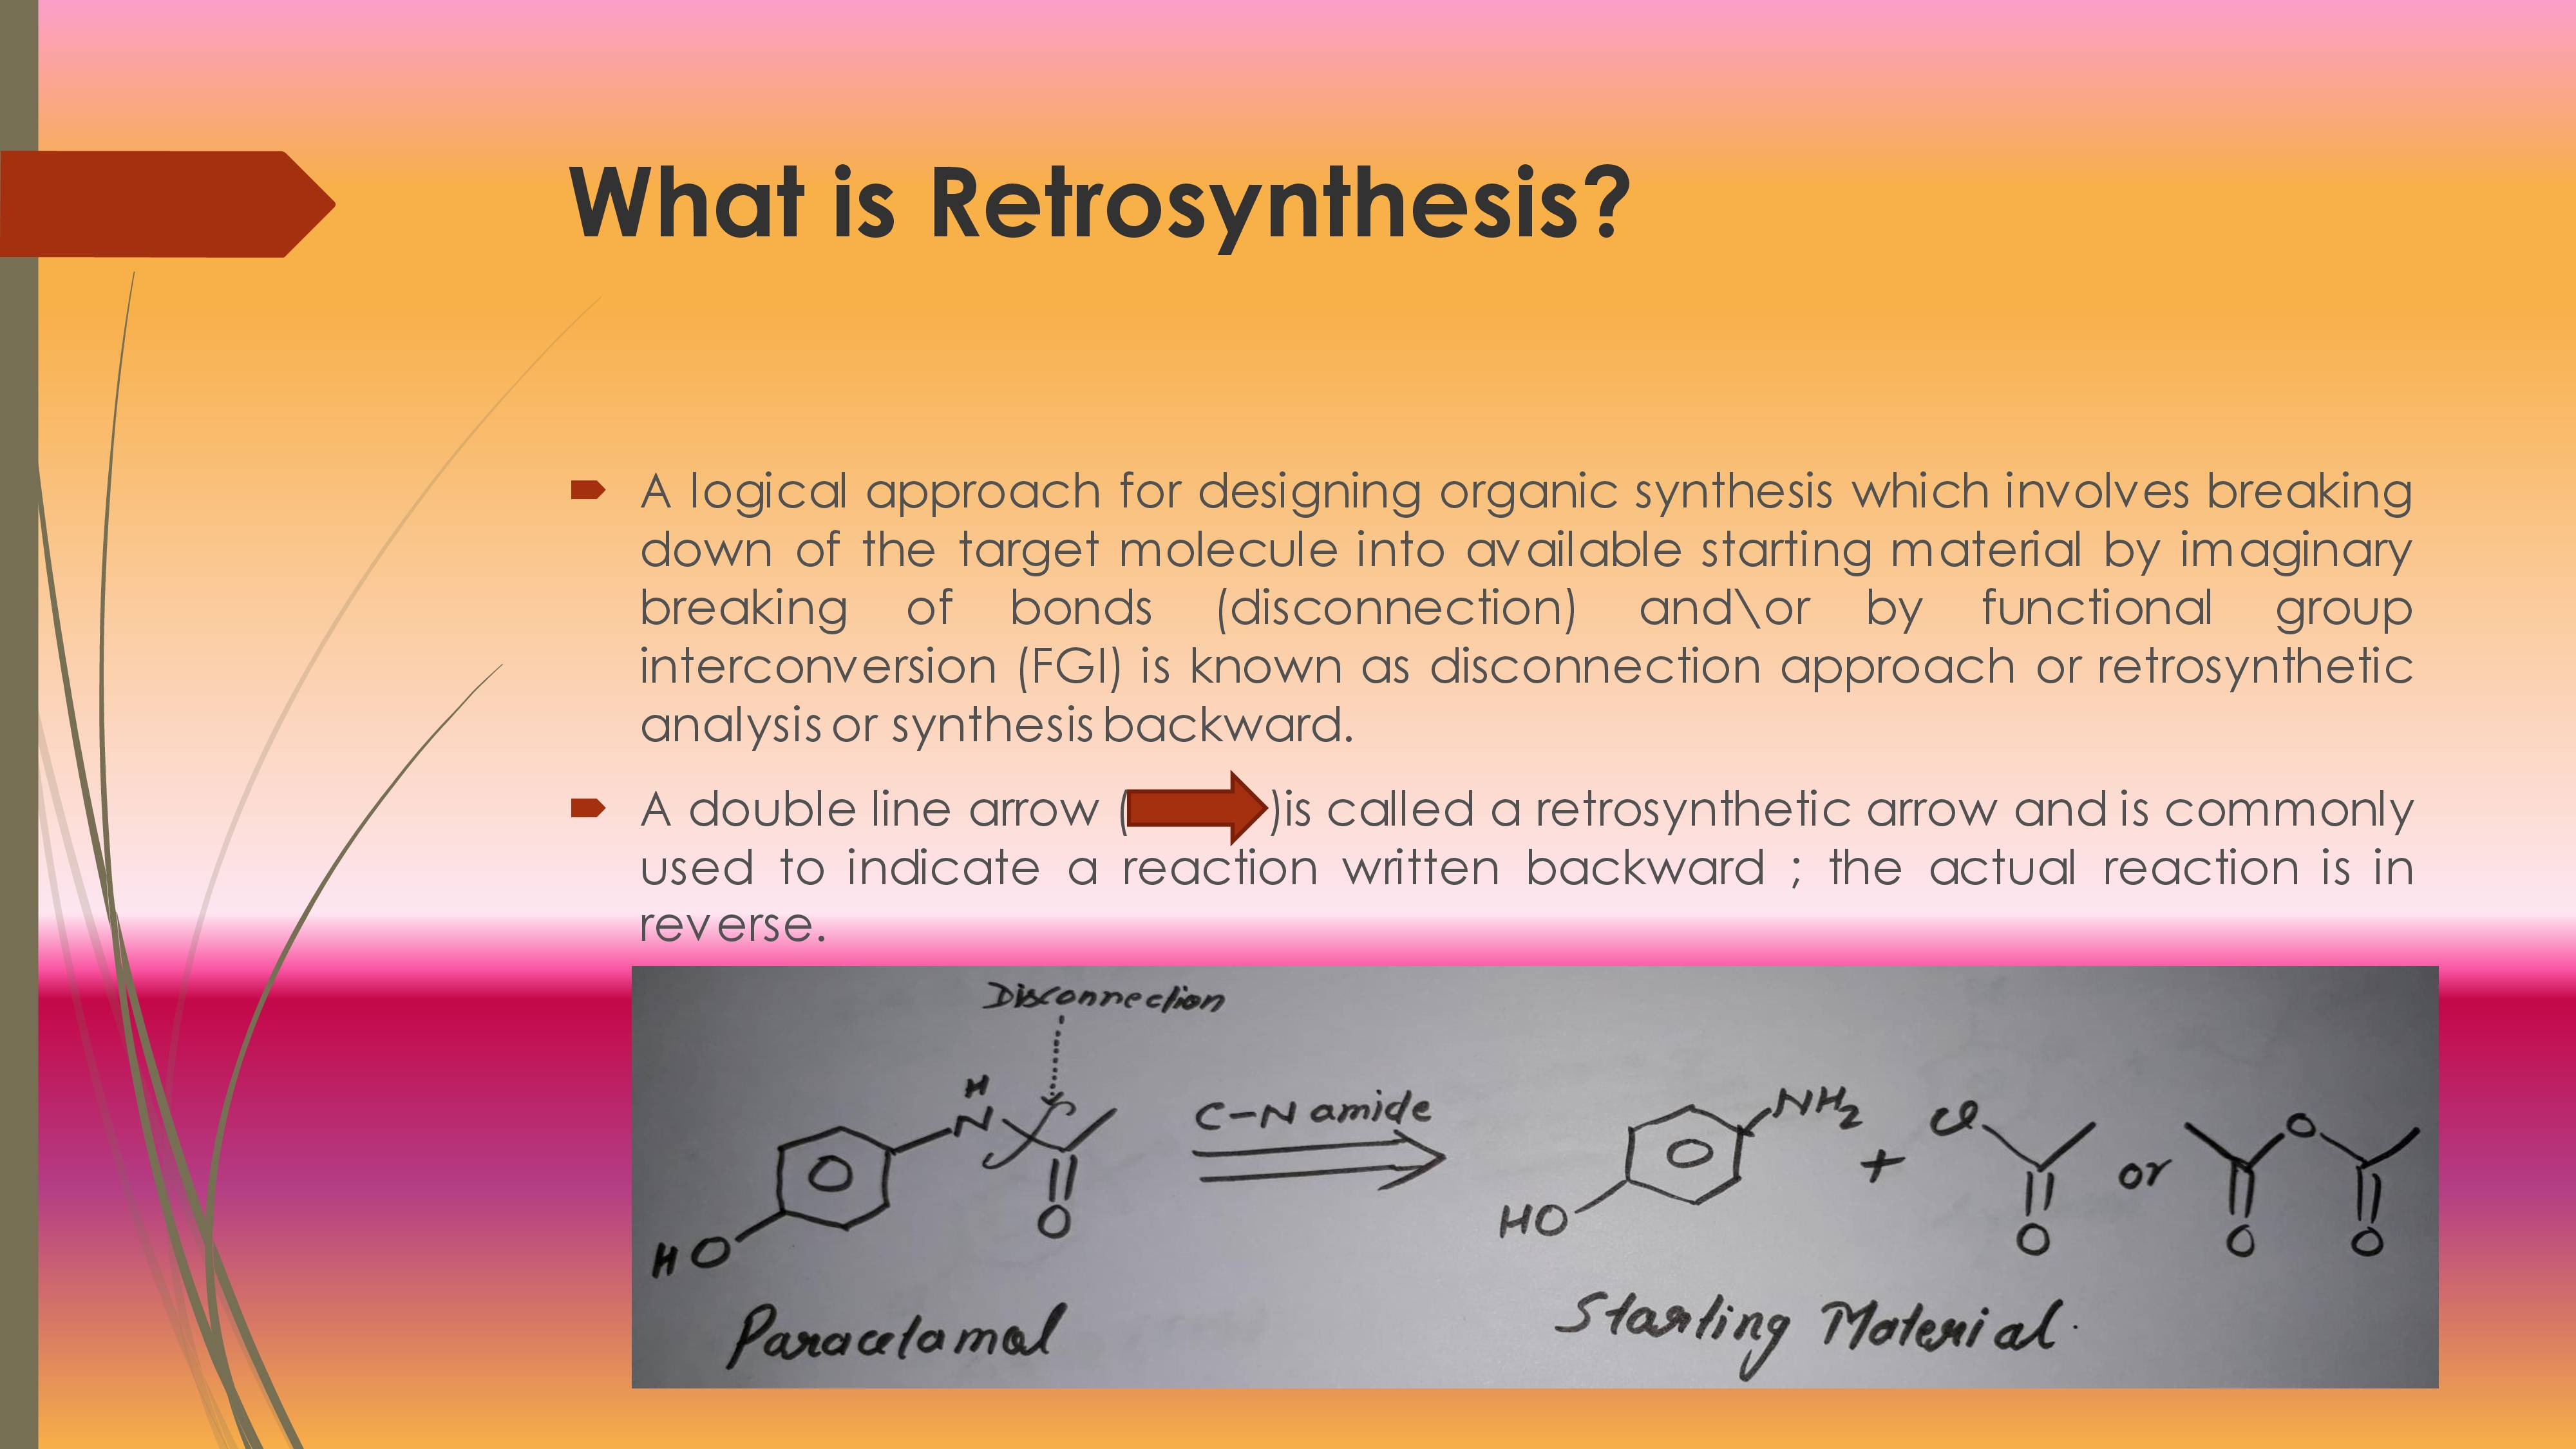

In [1]:
import sys
import time
from collections import defaultdict

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
import pandas as pd
IPythonConsole.ipython_3d=True
%pylab inline

RDKit WARNING: [16:51:42] Enabling RDKit 2019.09.1 jupyter extensions


Populating the interactive namespace from numpy and matplotlib


## Get your api key

In [2]:
# you need to install rxn4chemistry using pip

# pip install rxn4chemistry

#You will need to register and get an api key from here  https://rxn.res.ibm.com/rxn/user/profile

api_key='You api key here'
from rxn4chemistry import RXN4ChemistryWrapper
rxn4chemistry_wrapper = RXN4ChemistryWrapper(api_key=api_key)

In [3]:
# rxn4chemistry_wrapper.set_project('PROJECT_ID')
response = rxn4chemistry_wrapper.create_project('my_covid19_candidates')

## Choose the file contining your selected molecules

In [4]:

# File locations, this is the final output from your selection
SelectedsdfFilePath = 'selectedposeH.sdf'

In [5]:
selected_df = PandasTools.LoadSDF(SelectedsdfFilePath,molColName='Molecule', removeHs=True)

minimizedAffinity          name RFScoreVS_v2            ID  \
0          -5.03851  SYN 13975176     6.312364  SYN 13975176   
1          -3.77326  ASN 10790639     6.305832  ASN 10790639   
2          -5.91577  AEM 10028511      6.30018  AEM 10028511   
3          -5.96147  SYN 13975163     6.298634  SYN 13975163   
4          -5.11896  LMG 16204894     6.294883  LMG 16204894   

                                            Molecule  
0  <img data-content="rdkit/molecule" src="data:i...  
1  <img data-content="rdkit/molecule" src="data:i...  
2  <img data-content="rdkit/molecule" src="data:i...  
3  <img data-content="rdkit/molecule" src="data:i...  
4  <img data-content="rdkit/molecule" src="data:i...
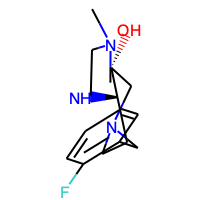
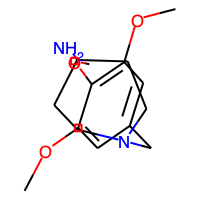
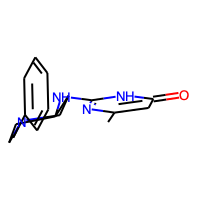
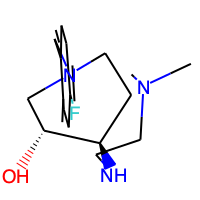
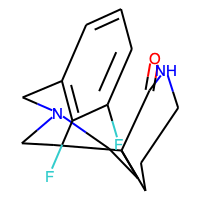

In [6]:
selected_df.head(5)

In [7]:
selected_df['SMILES'] = selected_df.Molecule.apply(Chem.MolToSmiles)

minimizedAffinity          name RFScoreVS_v2            ID  \
0          -5.03851  SYN 13975176     6.312364  SYN 13975176   
1          -3.77326  ASN 10790639     6.305832  ASN 10790639   
2          -5.91577  AEM 10028511      6.30018  AEM 10028511   
3          -5.96147  SYN 13975163     6.298634  SYN 13975163   
4          -5.11896  LMG 16204894     6.294883  LMG 16204894   

                                            Molecule  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                     SMILES  
0    CN(C)CCN[C@@H]1CCN(Cc2ccccc2F)C[C@H]1O  
1            COc1cc(CN2CCC(N)CC2)cc(OC)c1OC  
2    Cc1cc(=O)[nH]c(NC2CCN(Cc3ccccc3)CC2)n1  
3  CN(C)CCN[C@@H]1CCN(Cc2ccc(F)cc2)C[C@H]1O  
4          O=C1NCCCC12CCN(Cc1cccc(F)c1F)CC2
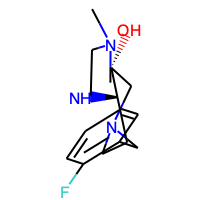
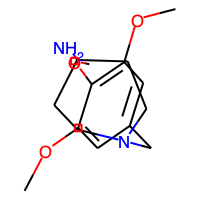
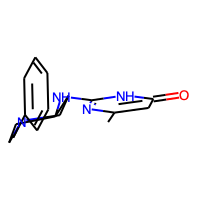
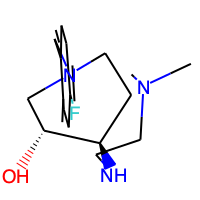
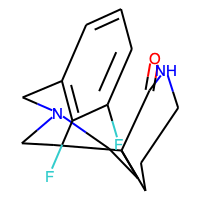

In [8]:
selected_df.head(5)

## Choose the name of the molecule you want to make

In [9]:
ID = 'LMG 16204894'
theSMILES = selected_df.loc[selected_df['name'] == ID]['SMILES'].values[0]
theSMILES

'O=C1NCCCC12CCN(Cc1cccc(F)c1F)CC2'

## Submit the SMILES for rerosynthesis

In [10]:
response = rxn4chemistry_wrapper.predict_automatic_retrosynthesis(product=theSMILES)

In [13]:
# rerun this until the status is 'SUCCESS', keep in mind the server allows only 5 requests per minute
# and a timeout between consecutive requests of 2 seconds
#If it times out, wait a couple of minutes and rerun.

import time

while True:
    results = rxn4chemistry_wrapper.get_predict_automatic_retrosynthesis_results(response['prediction_id'])
    if results['status'] == 'SUCCESS':
        break
    time.sleep(30) #check every 30 secs

In [14]:
def collect_reactions(tree):
    reactions = []
    if 'children' in tree and len(tree['children']):
        reactions.append(
            AllChem.ReactionFromSmarts('{}>>{}'.format(
                '.'.join([node['smiles'] for node in tree['children']]),
                tree['smiles']
            ), useSmiles=True)
        )
    for node in tree['children']:
        reactions.extend(collect_reactions(node))
    return reactions


## Display the suggested routes

Showing path 0 with confidence 0.983:


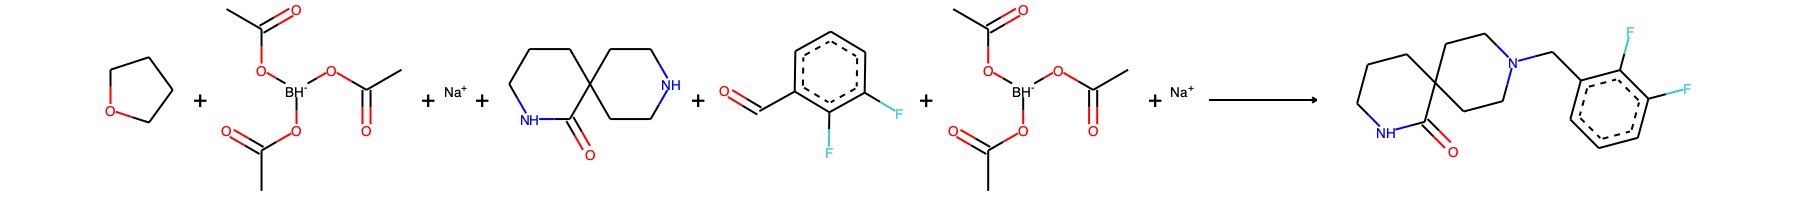

Showing path 1 with confidence 0.982:


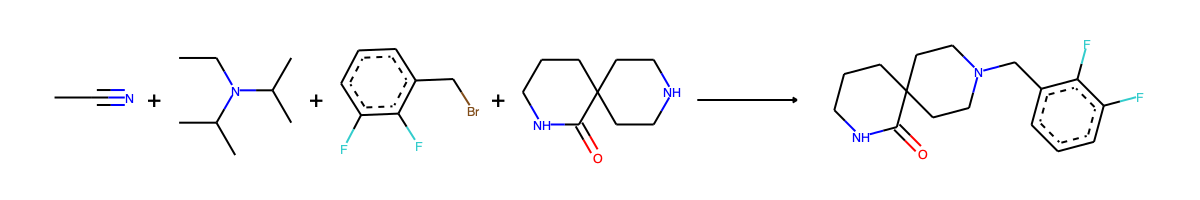

Showing path 2 with confidence 0.978:


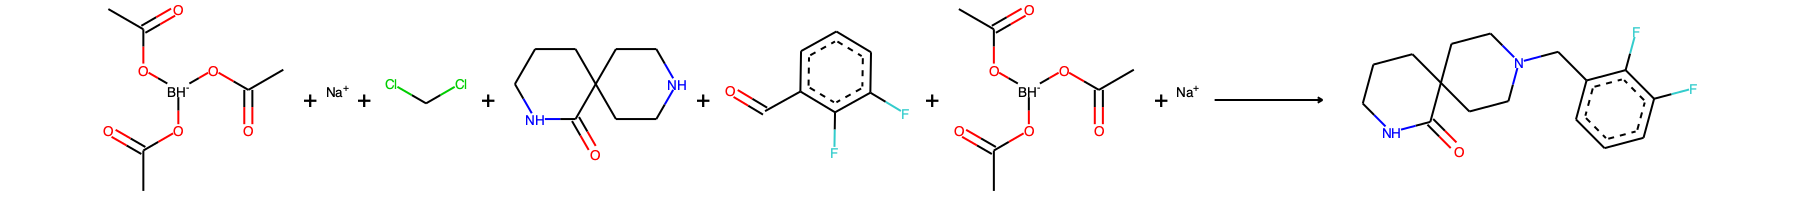

Showing path 3 with confidence 0.978:


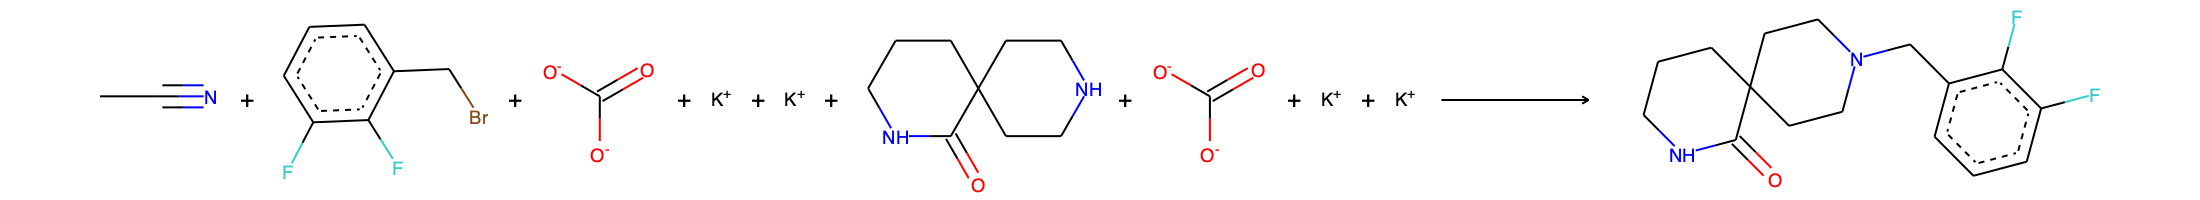

Showing path 4 with confidence 0.976:


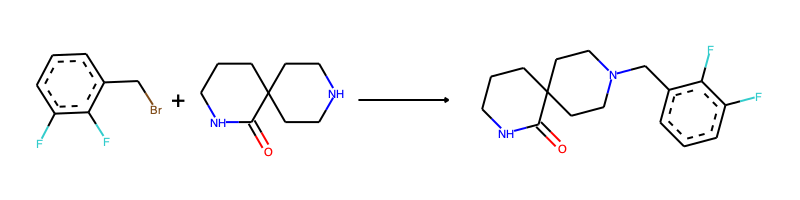

Showing path 5 with confidence 0.976:


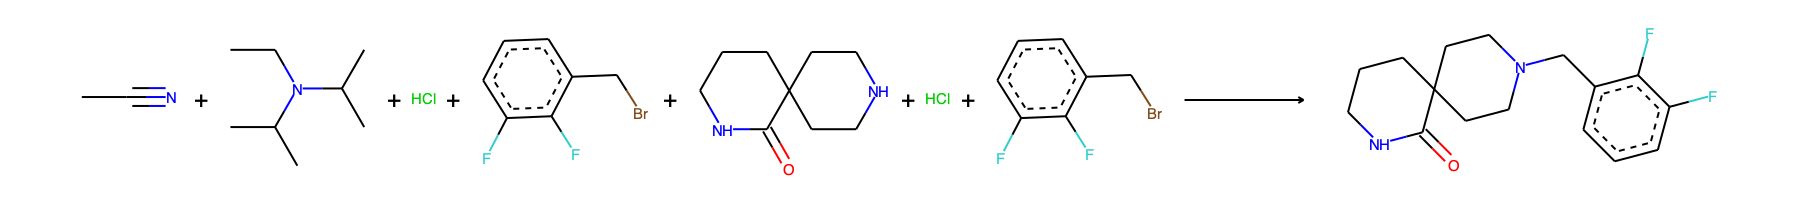

Showing path 6 with confidence 0.976:


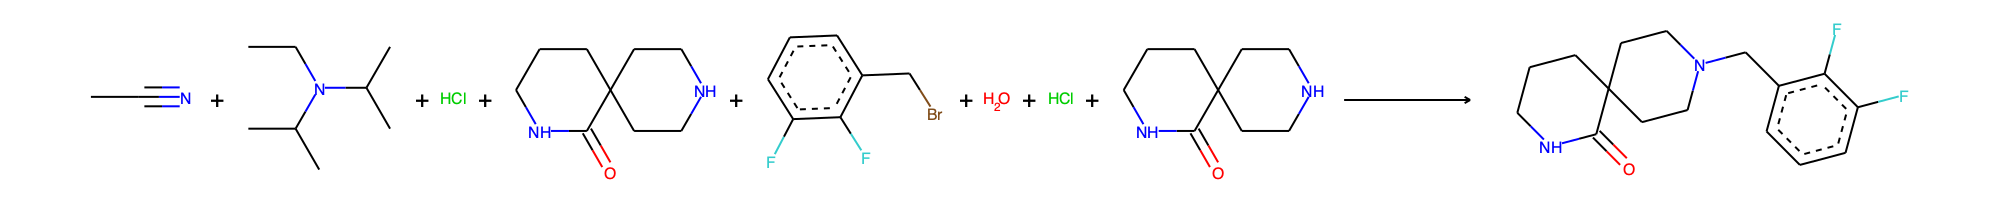

Showing path 7 with confidence 0.975:


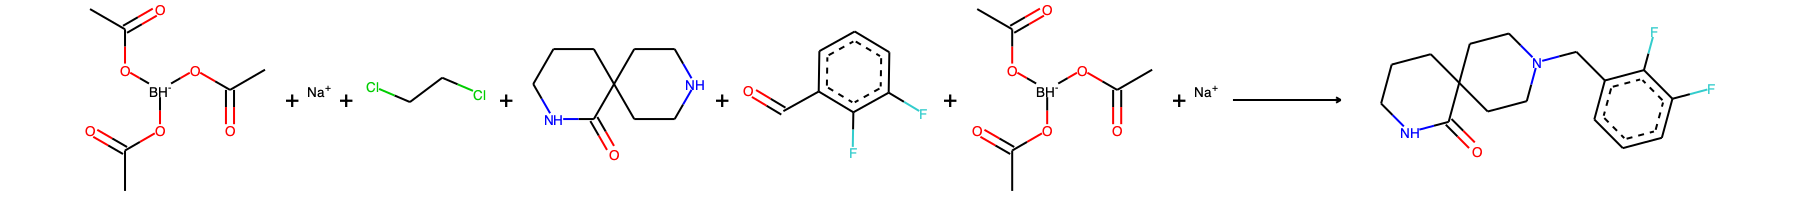

Showing path 8 with confidence 0.974:


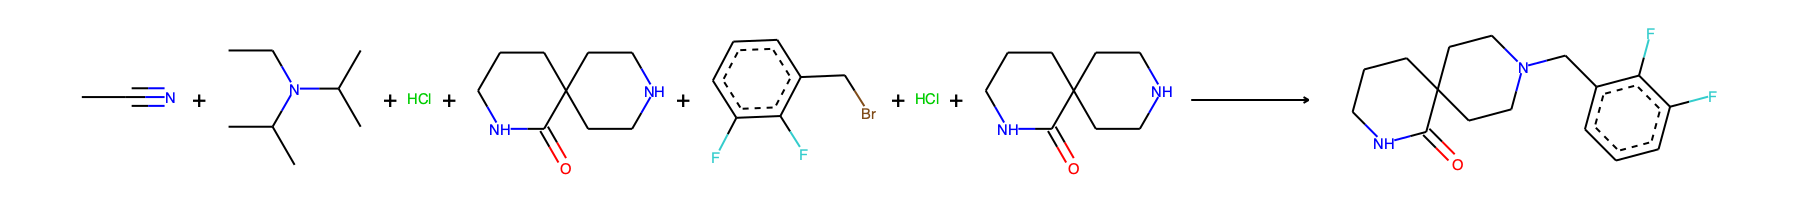

Showing path 9 with confidence 0.971:


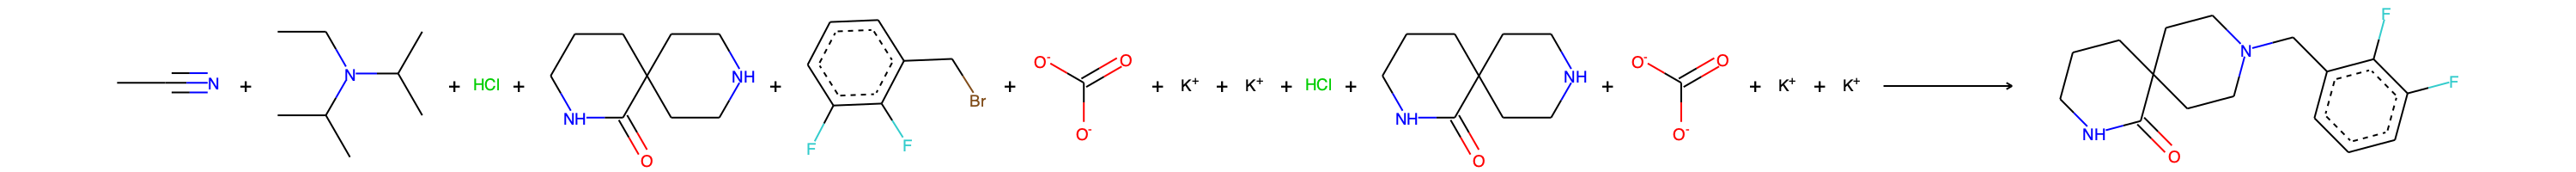

Showing path 10 with confidence 0.966:


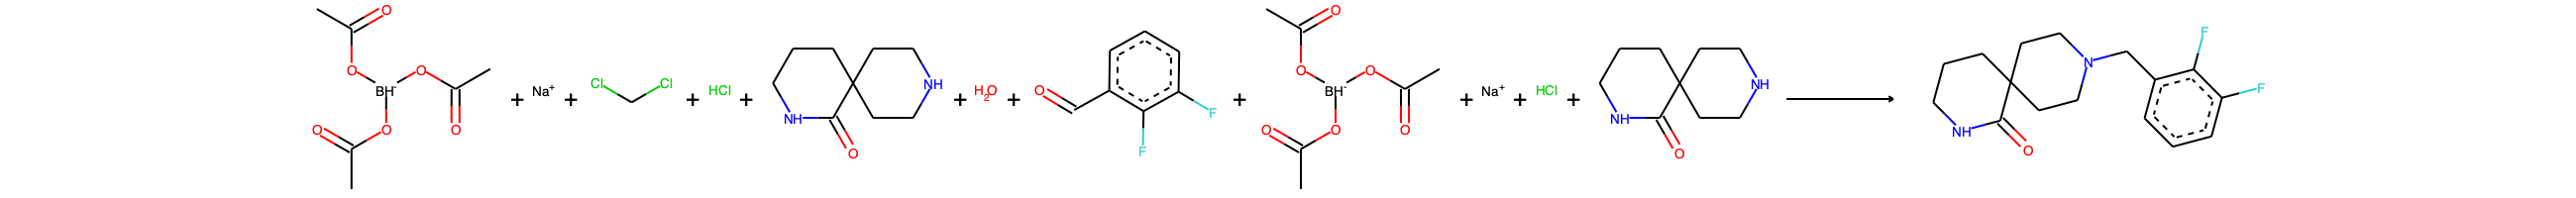

Showing path 11 with confidence 0.965:


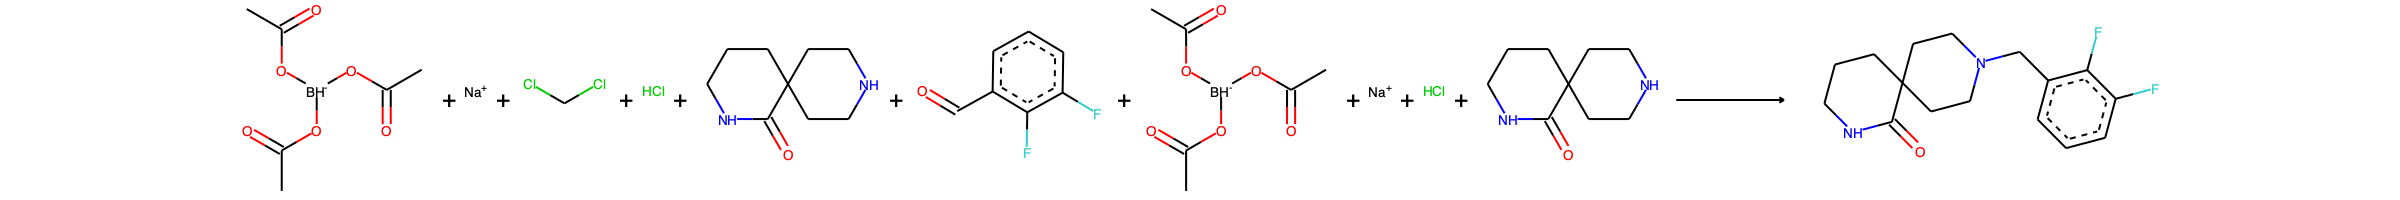

Showing path 12 with confidence 0.87:


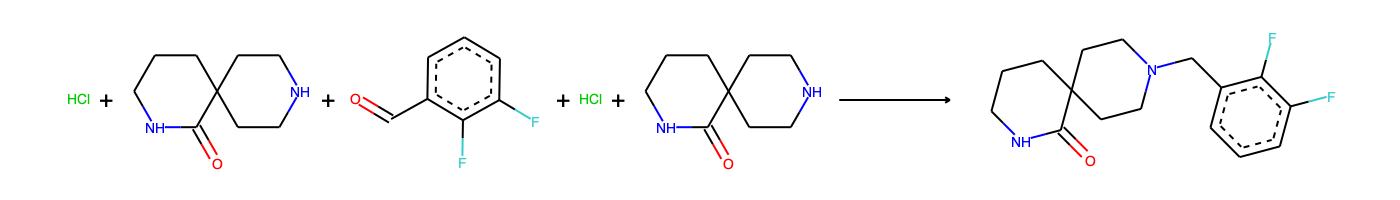

In [15]:
for index, path in enumerate(results['retrosynthetic_paths']):
    print('Showing path {} with confidence {}:'.format(index, path['confidence']))
    for reaction in collect_reactions(path):
        display(Chem.Draw.ReactionToImage(reaction))

In [19]:
#to save images
for index, path in enumerate(results['retrosynthetic_paths']):
	print('Showing path {} with confidence {}:'.format(index, path['confidence']))
	for i, reaction in enumerate(collect_reactions(path)):
		img = Chem.Draw.ReactionToImage(reaction)
		img.save(f"{index}-{i}.png")

Showing path 0 with confidence 0.983:
Showing path 1 with confidence 0.982:
Showing path 2 with confidence 0.978:
Showing path 3 with confidence 0.978:
Showing path 4 with confidence 0.976:
Showing path 5 with confidence 0.976:
Showing path 6 with confidence 0.976:
Showing path 7 with confidence 0.975:
Showing path 8 with confidence 0.974:
Showing path 9 with confidence 0.971:
Showing path 10 with confidence 0.966:
Showing path 11 with confidence 0.965:
Showing path 12 with confidence 0.87:
